In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
from scipy.ndimage import gaussian_filter

# Constants
E_b = 1000.0 # Pa
E_c = 100.0 # Pa
E_s = 1.0 # Pa
h_b = 1e-2 # m
h_c = 1e-5 # m
gamma0 = 2.0 # N/m
p = 1.0


K_c = (E_c * (h_c)**3) /9
hb_hc_ratio = h_b / h_c 
Eb_Ec_ratio = E_b / E_c
Es_Ec_ratio = E_s / E_c
# non_linear_prefactor = 9 * Eb_Ec_ratio * (hb_hc_ratio)**(1/3) 
# f_el_prefactor = 3 * Es_Ec_ratio * (hb_hc_ratio)**(1/3)

non_linear_prefactor = 1.0
f_el_prefactor = 1.0

gamma_c = (3 * K_c * E_s**2 )**(1/3)
lambda_c = 2 * np.pi * (K_c / E_s)**(1/3)

print(lambda_c)
print(gamma0 / gamma_c)
print(non_linear_prefactor)
print(f_el_prefactor)

0.00014020570920327251
62144.65011907714
1.0
1.0


![title](equations.jpg)

![title](tgdl.jpg)

![title](first_order_semi_implicit.jpg)

![title](image.png)

# Testing Basics


In [2]:
def initialize_grid(total_time=5.0, Nx=128, Ny=128, Lx=128.0, Ly=128.0, dt=0.01):

    # Parameters for the domain
    dx, dy = Lx / Nx, Ly / Ny  # Grid spacing
    steps = int(total_time / dt)

    # Create spatial grid centered at (0,0)
    x = np.linspace(-Lx / 2, Lx / 2, Nx, endpoint=False)
    y = np.linspace(-Ly / 2, Ly / 2, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y)

    # Wavenumber grids in Fourier space (centered)
    kx_unshifted = 2 * np.pi * fftfreq(Nx, d=dx)
    ky_unshifted = 2 * np.pi * fftfreq(Ny, d=dy)
    kx = fftshift(kx_unshifted)
    ky = fftshift(ky_unshifted)
    KX, KY = np.meshgrid(kx, ky)  # Shift to center k-space around (0,0)

    K_squared = KX**2 + KY**2
    K = np.sqrt(K_squared)
    K_fourth = K_squared**2

    # Handling division by zero at k=0
    K[K == 0] = 1e-20
    center_idx = Nx // 2

    return Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx

def fft_transform(field, normalize=True):
    transformed = fftshift(fft2(field))
    if normalize:
        transformed /= field.size  # Normalize by grid size
    return transformed

def ifft_transform(field_tilde, normalize=True, real_output=True):
    field = ifft2(ifftshift(field_tilde))
    if normalize:
        field *= field_tilde.size  # Normalize by grid size
    return np.real(field) if real_output else field


def plot_3d(x, y, z, title):
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('w')
    ax.view_init(elev=45, azim=-135)
    ax.plot_surface(x, y, z, cmap='viridis', rstride=1, cstride=1, antialiased=True)

    mappable = plt.cm.ScalarMappable(cmap='viridis')
    mappable.set_array(z)
    plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
    plt.show()

def plot_2d(x, y, z, title):
    
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(x, y, z, cmap='viridis')
    plt.colorbar(label='w')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
    plt.show()

def animate_w_and_w_tilde(w_array, w_tilde_array, X, Y, KX, KY, dt, title):
    # Initialize the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Setup for w (real space)
    real_space_plot = ax2.pcolormesh(X, Y, w_array[0], cmap='viridis', shading='auto')
    ax2.set_title('Real Space (w)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_aspect('equal')
    real_colorbar = plt.colorbar(real_space_plot, ax=ax2)

    # Setup for w_tilde (Fourier space)
    fourier_space_plot = ax1.pcolormesh(KX, KY, np.abs(w_tilde_array[0]), cmap='viridis', shading='auto')
    ax1.set_title('Fourier Space (w_tilde)')
    ax1.set_xlabel('kx')
    ax1.set_ylabel('ky')
    ax1.set_aspect('equal')
    fourier_colorbar = plt.colorbar(fourier_space_plot, ax=ax1)

    # Update function for animation
    def update(frame):
        real_space_plot.set_array(w_array[frame].ravel())
        real_space_plot.set_clim(vmin=w_array[frame].min(), vmax=w_array[frame].max())  # Dynamically rescale
        real_colorbar.update_normal(real_space_plot)

        # Update Fourier space data
        fourier_space_plot.set_array(np.abs(w_tilde_array[frame]).ravel())
        fourier_space_plot.set_clim(vmin=np.abs(w_tilde_array[frame]).min(), vmax=np.abs(w_tilde_array[frame]).max())  # Dynamically rescale
        fourier_colorbar.update_normal(fourier_space_plot)

        # Update titles with the current time
        ax2.set_title(f'Real Space (w), Time: {frame * dt:.2f}')
        ax1.set_title(f'Fourier Space (w_tilde), Time: {frame * dt:.2f}')
        return fourier_space_plot, real_space_plot

    # Create the animation
    ani = FuncAnimation(fig, update, frames=len(w_array), blit=False)
    ani.event_source.interval = 2000  # Set the interval between frames in milliseconds
    # Save the animation as a video file or show it
    ani.save(title, fps=10, extra_args=['-vcodec', 'libx264'])
    plt.show()

def generate_smooth_random_2d_array(size=(100, 100), sigma=1.0):
    # Generate random noise
    noise = np.random.normal(size=size)
    
    # Apply Gaussian filter to smooth the noise
    smooth_array = gaussian_filter(noise, sigma=sigma)
    
    return smooth_array

# plt.imshow(smooth_array, cmap='viridis')
# plt.colorbar()
# plt.title('Smooth Random 2D Array (Gaussian Filter)')
# plt.show()

Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid()

# w = np.exp((-X*X - Y*Y)/4086) * 0.1

w = np.sin(2 * np.pi * X / 32)

w_tilde = fft_transform(w)

# plot_2d(X, Y, w, 'Initial condition')
# plot_2d(KX, KY, np.abs(w_tilde), 'Initial condition in Fourier space')

# plot_3d(X, Y, w, 'Initial condition')
# plot_3d(KX, KY, np.abs(w_tilde), 'Initial condition in Fourier space')

# Linear Part

In [3]:
def linear_first_order_scheme_for_w(w_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0):

    w_tilde_new = w_tilde / (1 + dt * (K_fourth - gamma0 * K_squared + 2*K*f_el_prefactor))

    return w_tilde_new

def linear_first_order_scheme_for_u1(u1_tilde, dt, K_squared, K, f_el_prefactor, KY):

    u1_tilde_new = u1_tilde / (1 + dt * (f_el_prefactor * (2 * K_squared - KY**2)/K))

    return u1_tilde_new

def linear_first_order_scheme_for_u2(u2_tilde, dt, K_squared, K, f_el_prefactor, KX):

    u2_tilde_new = u2_tilde / (1 + dt * (f_el_prefactor * (2 * K_squared - KX**2)/K))

    return u2_tilde_new


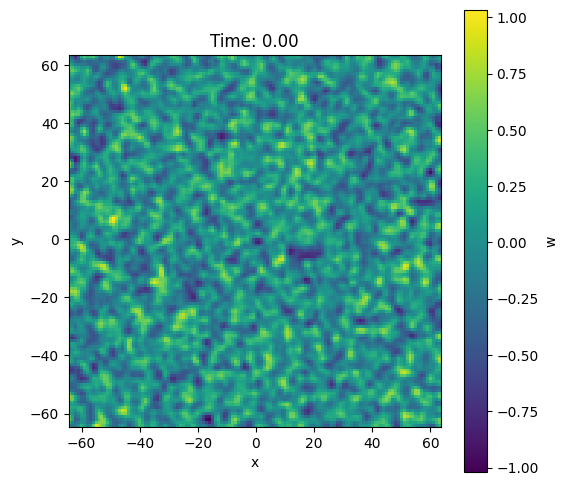

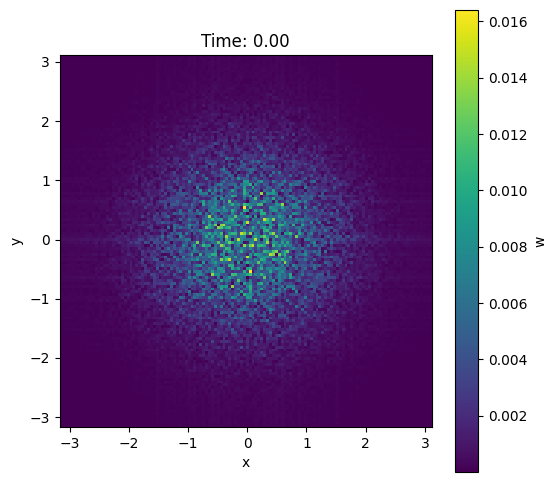

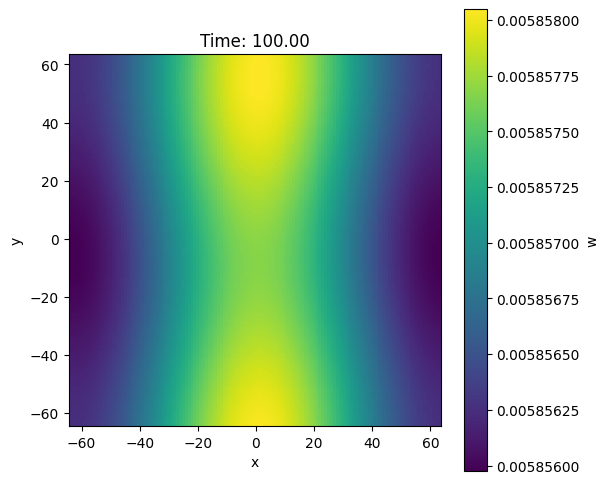

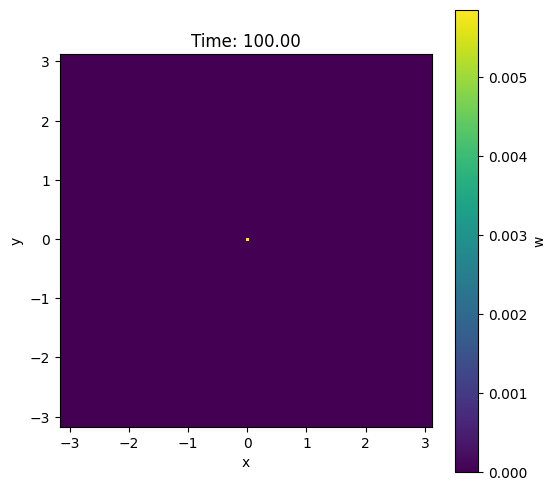

In [4]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(101)

gamma0 = 1.0
non_linear_prefactor = 1.0
f_el_prefactor = 1.0

# w = generate_smooth_random_2d_array(size=(Nx, Ny))  # Initial condition
# w = np.ones((Nx, Ny))9
# w = np.exp((-X*X - Y*Y)/256)
# w = np.exp((-X*X - Y*Y))
#w = np.cos(2 * np.pi * X / 32) + np.cos(2 * np.pi * Y / 32)
# u1 = np.zeros((Nx, Ny))  # Initial displacement in x direction
# u2 = np.zeros((Nx, Ny))  # Initial displacement in y direction

w = generate_smooth_random_2d_array(size=(int(Nx), int(Ny)), sigma=1.0)
# w = np.ones((int(Nx/2), int(Ny/2))) * 0.1
u1 = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=1.0)
u2 = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=1.0)

w = np.tile(w, (Nx // w.shape[0], Ny // w.shape[1]))
u1 = np.tile(u1, (Nx // u1.shape[0], Ny // u1.shape[1]))
u2 = np.tile(u2, (Nx // u2.shape[0], Ny // u2.shape[1]))

w_values = []  # List to store the value of w at center (0,0) over time
# Fourier transform of w
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)

w_array = []
w_tilde_array = []


for step in range(steps):
    
    w_tilde_new = linear_first_order_scheme_for_w(w_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0)
    u1_tilde_new = linear_first_order_scheme_for_u1(u1_tilde, dt, K_squared, K, f_el_prefactor, KY)
    u2_tilde_new = linear_first_order_scheme_for_u2(u2_tilde, dt, K_squared, K, f_el_prefactor, KX)
    
    # Inverse Fourier transform to get updated w in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)

    # Update Fourier components for the next step
    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new

    # Store the value of w at (0,0) for analysis
    if step % 100 == 0:
        x_idx = 21
        y_idx = 0
        storing_idx = (center_idx + x_idx, center_idx + y_idx)
        epsilon = 1e-10  # A small value to avoid log(0)
        # w_values.append(math.log(np.abs(w_tilde_new[storing_idx])))

    if step % 10000 == 0:
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
    # Visualization every 1000 steps
    # if step % 100 == 0:
        
    #     # plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
    #     # plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
    #     # plot_3d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
    #     # plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
    #     # plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')

    #     w_array.append(w)
    #     w_tilde_array.append(w_tilde)


        # print(f'Max value of w: {np.max(w)}')
        #plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')

        # plt.figure(figsize=(6, 4))
        # plt.plot(kx, w_tilde[center_idx, :], label='w_tilde ')
        # plt.xlabel('x')
        # plt.ylabel('w_tilde ')
        # plt.title('w_tilde  along x axis')
        # plt.legend()
        # plt.show()
        # # Find the first non-zero value in w_tilde 
        # non_zero_indices = np.nonzero(w_tildeb)
        # first_non_zero_index = non_zero_indices[1][0]  # Get the first non-zero index in the x-direction
        # kx_value = kx[first_non_zero_index]
        # print(f'The kx value of the first non-zero w_tildeb is: {kx_value}')
        # print(f'Max value of w_tildeb: {np.max(w_tildeb)}')

# After the simulation loop is complete
# animate_w_and_w_tilde(w_array, w_tilde_array, X, Y, KX, KY, dt, 'linear_first_order_scheme.mp4')

# kx_values = kx
# kx_squared = kx_values**2
# kx_fourth = kx_values**4

# plt.figure(figsize=(6, 4))
# plt.plot(kx_values, -kx_fourth + gamma0 * kx_squared, label=r'$-k_x^4 + \gamma0 k_x^2$')
# plt.xlabel(r'$k_x$')
# plt.ylabel(r'$-k_x^4 + \gamma0 k_x^2$')
# plt.title(r'Plot of $-k_x^4 + \gamma0 k_x^2$')
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)
# plt.xlim(-1, 1)
# # Mark the points where the curve touches the x-axis
# zero_crossings = np.where(np.diff(np.sign(-kx_fourth + gamma0 * kx_squared)))[0]
# for idx in zero_crossings:
#     plt.plot(kx_values[idx], 0, 'ro')  # 'ro' for red circles
# plt.legend()
# plt.show()
# print("kx values where the curve crosses the x-axis:")
# for idx in zero_crossings:
#     print(kx_values[idx])

# Fit a linear model to the data
# plt.figure(figsize=(10, 6))
# plt.plot(range(0, steps, 100), w_values, marker='o')
# plt.title('Value of w over time')
# plt.xlabel('Time step')
# plt.ylabel('w')
# plt.grid(True)
# plt.show()

# coefficients = np.polyfit(range(0, steps, 100), w_values, 1)
# print(f'fourier component: {KX[center_idx + x_idx, center_idx + y_idx], KY[center_idx + x_idx, center_idx + y_idx]}')
# print(K_fourth[center_idx + x_idx, center_idx + y_idx], K_squared[center_idx + x_idx, center_idx + y_idx])
# print(f'Theoretical slope: {(gamma0*K_squared[center_idx + x_idx, center_idx + y_idx] - K_fourth[center_idx + x_idx, center_idx + y_idx])*dt}')
# slope = coefficients[0]

# print(f"The slope of the graph of 10 10 is: {slope}")

# Non Linear Term

In [5]:
def derivative_x_fourier(field_tilde, KX):
    return 1j * KX * field_tilde

def derivative_y_fourier(field_tilde, KY):
    return 1j * KY * field_tilde

def second_derivative_x_fourier(field_tilde, KX):
    return -KX**2 * field_tilde

def second_derivative_y_fourier(field_tilde, KY):
    return -KY**2 * field_tilde

def cross_derivative_fourier(field_tilde, KX, KY):
    return -KX*KY * field_tilde

def compute_non_linear_for_w(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor):

    # Compute first derivatives in Fourier space
    dw_dx_tilde = derivative_x_fourier(w_tilde, KX)
    dw_dy_tilde = derivative_y_fourier(w_tilde, KY)

    du1_dx_tilde = derivative_x_fourier(u1_tilde, KX)
    du1_dy_tilde = derivative_y_fourier(u1_tilde, KY)

    du2_dx_tilde = derivative_x_fourier(u2_tilde, KX)
    du2_dy_tilde = derivative_y_fourier(u2_tilde, KY)
    
    # Compute second derivatives in Fourier space

    d2w_dx2_tilde = second_derivative_x_fourier(w_tilde, KX)
    d2w_dy2_tilde = second_derivative_y_fourier(w_tilde, KY)
    d2w_dxdy_tilde = cross_derivative_fourier(w_tilde, KX, KY)

    d2u1_dx2_tilde = second_derivative_x_fourier(u1_tilde, KX)
    d2u1_dy2_tilde = second_derivative_y_fourier(u1_tilde, KY)
    d2u1_dxdy_tilde = cross_derivative_fourier(u1_tilde, KX, KY)

    d2u2_dx2_tilde = second_derivative_x_fourier(u2_tilde, KX)
    d2u2_dy2_tilde = second_derivative_y_fourier(u2_tilde, KY)
    d2u2_dxdy_tilde = cross_derivative_fourier(u2_tilde, KX, KY)

    # Transform Back

    dw_dx = ifft_transform(dw_dx_tilde)
    dw_dy = ifft_transform(dw_dy_tilde)

    du1_dx = ifft_transform(du1_dx_tilde)
    du1_dy = ifft_transform(du1_dy_tilde)

    du2_dx = ifft_transform(du2_dx_tilde)
    du2_dy = ifft_transform(du2_dy_tilde)

    d2w_dx2 = ifft_transform(d2w_dx2_tilde)
    d2w_dy2 = ifft_transform(d2w_dy2_tilde)
    d2w_dxdy = ifft_transform(d2w_dxdy_tilde)

    d2u1_dx2 = ifft_transform(d2u1_dx2_tilde)
    d2u1_dy2 = ifft_transform(d2u1_dy2_tilde)
    d2u1_dxdy = ifft_transform(d2u1_dxdy_tilde)
    
    d2u2_dx2 = ifft_transform(d2u2_dx2_tilde)
    d2u2_dy2 = ifft_transform(d2u2_dy2_tilde)
    d2u2_dxdy = ifft_transform(d2u2_dxdy_tilde)
    
    # Compute terms as per the expanded expression
    term1 = d2w_dx2 * (2 * du1_dx + 2 * dw_dx**2)
    term2 = d2w_dy2 * (2 * du2_dy + 2 * dw_dy**2)
    term3 = 2 * d2w_dxdy * (du1_dy + du2_dx + dw_dx * dw_dy)

    term4 = dw_dx * (2 * d2u1_dx2 + 2 * d2w_dx2 * dw_dx)
    term5 = dw_dy * (2 * d2u2_dy2 + 2 * d2w_dy2 * dw_dy)

    term6 = dw_dx * (d2u1_dy2 + d2u2_dxdy + d2w_dxdy * dw_dy + dw_dx * d2w_dy2)
    term7 = dw_dy * (d2u2_dx2 + d2u1_dxdy + d2w_dxdy * dw_dx + dw_dy * d2w_dx2)
    
    # Sum all terms
    total_term_real = term1 + term2 + term3 + term4 + term5 + term6 + term7
    
    # Multiply by the non-linear prefactor
    total_term_real *= non_linear_prefactor
    
    # Transform back to Fourier space
    total_term_tilde = ifft_transform(total_term_real)
    
    return total_term_tilde

def compute_non_linear_for_u1(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor):

    # Compute first derivatives in Fourier space
    dw_dx_tilde = derivative_x_fourier(w_tilde, KX)
    dw_dy_tilde = derivative_y_fourier(w_tilde, KY)
    
    # Compute second derivatives in Fourier space

    d2w_dx2_tilde = second_derivative_x_fourier(w_tilde, KX)
    d2w_dy2_tilde = second_derivative_y_fourier(w_tilde, KY)
    d2w_dxdy_tilde = cross_derivative_fourier(w_tilde, KX, KY)

    d2u1_dx2_tilde = second_derivative_x_fourier(u1_tilde, KX)
    d2u1_dy2_tilde = second_derivative_y_fourier(u1_tilde, KY)

    d2u2_dxdy_tilde = cross_derivative_fourier(u2_tilde, KX, KY)

    # Transform Back

    dw_dx = ifft_transform(dw_dx_tilde)
    dw_dy = ifft_transform(dw_dy_tilde)

    d2w_dx2 = ifft_transform(d2w_dx2_tilde)
    d2w_dy2 = ifft_transform(d2w_dy2_tilde)
    d2w_dxdy = ifft_transform(d2w_dxdy_tilde)

    d2u1_dx2 = ifft_transform(d2u1_dx2_tilde)
    d2u1_dy2 = ifft_transform(d2u1_dy2_tilde)

    d2u2_dxdy = ifft_transform(d2u2_dxdy_tilde)

    # Compute terms as per the expanded expression
    term1 = 2 * d2u1_dx2 + 2 * d2w_dx2 * dw_dx
    term2 = d2u1_dy2 + d2u2_dxdy + d2w_dxdy * dw_dy + dw_dx * d2w_dy2

    total_term_real = term1 + term2

    # Multiply by the non-linear prefactor
    total_term_real *= non_linear_prefactor

    # Transform back to Fourier space
    total_term_tilde = ifft_transform(total_term_real)

    return total_term_tilde

def compute_non_linear_for_u2(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor):
    
    # Compute first derivatives in Fourier space
    dw_dx_tilde = derivative_x_fourier(w_tilde, KX)
    dw_dy_tilde = derivative_y_fourier(w_tilde, KY)
    
    # Compute second derivatives in Fourier space

    d2w_dx2_tilde = second_derivative_x_fourier(w_tilde, KX)
    d2w_dy2_tilde = second_derivative_y_fourier(w_tilde, KY)
    d2w_dxdy_tilde = cross_derivative_fourier(w_tilde, KX, KY)

    d2u1_dxdy_tilde = cross_derivative_fourier(u1_tilde, KX, KY)

    d2u2_dx2_tilde = second_derivative_x_fourier(u2_tilde, KX)
    d2u2_dy2_tilde = second_derivative_y_fourier(u2_tilde, KY)

    # Transform Back

    dw_dx = ifft_transform(dw_dx_tilde)
    dw_dy = ifft_transform(dw_dy_tilde)

    d2w_dx2 = ifft_transform(d2w_dx2_tilde)
    d2w_dy2 = ifft_transform(d2w_dy2_tilde)
    d2w_dxdy = ifft_transform(d2w_dxdy_tilde)

    d2u1_dxdy = ifft_transform(d2u1_dxdy_tilde)
    
    d2u2_dx2 = ifft_transform(d2u2_dx2_tilde)
    d2u2_dy2 = ifft_transform(d2u2_dy2_tilde)

    # Compute terms as per the expanded expression
    term1 = 2 * d2u2_dy2 + 2 * d2w_dy2 * dw_dy
    term2 = d2u2_dx2 + d2u1_dxdy + d2w_dxdy * dw_dx + dw_dy * d2w_dx2

    total_term_real = term1 + term2

    # Multiply by the non-linear prefactor
    total_term_real *= non_linear_prefactor

    # Transform back to Fourier space
    total_term_tilde = ifft_transform(total_term_real)

    return total_term_tilde


def laplacian_w(field_tilde, K):
    return -K**2 * field_tilde

def non_linear_first_order_scheme_for_w(w_tilde, u1_tilde, u2_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0, non_linear_prefactor, p):

    term1 = compute_non_linear_for_w(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor)
    
    laplacian_real = ifft_transform(laplacian_w(w_tilde, K))
    w = ifft_transform(w_tilde)
    term2_real = w* laplacian_real
    term2 = p * fft_transform(term2_real)
    
    w_tilde_new = dt * (term1 + term2)/ (1 + dt * (K_fourth - gamma0 * K_squared + 2*K*f_el_prefactor))

    return w_tilde_new

def non_linear_first_order_scheme_for_u1(w_tilde, u1_tilde, u2_tilde, dt, K_squared, K, f_el_prefactor, KY, non_linear_prefactor):

    term1 = compute_non_linear_for_u1(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor)
    term2 = f_el_prefactor * u2_tilde * (KX * KY)/K

    u1_tilde_new = dt * (term1 - term2)/ (1 + dt * (f_el_prefactor * (2 * K_squared - KY**2)/K))

    return u1_tilde_new

def non_linear_first_order_scheme_for_u2(w_tilde, u1_tilde, u2_tilde, dt, K_squared, K, f_el_prefactor, KX, non_linear_prefactor):
    
        term1 = compute_non_linear_for_u2(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor)
        term2 = f_el_prefactor * u1_tilde * (KX * KY)/K
    
        u2_tilde_new = dt * (term1 - term2)/ (1 + dt * (f_el_prefactor * (2 * K_squared - KX**2)/K))
    
        return u2_tilde_new


C:\Users\Hp\AppData\Local\Temp\ipykernel_13460\1405566998.py:66: RuntimeWarning: overflow encountered in square
  term1 = d2w_dx2 * (2 * du1_dx + 2 * dw_dx**2)
C:\Users\Hp\AppData\Local\Temp\ipykernel_13460\1405566998.py:67: RuntimeWarning: overflow encountered in square
  term2 = d2w_dy2 * (2 * du2_dy + 2 * dw_dy**2)
C:\Users\Hp\AppData\Local\Temp\ipykernel_13460\1405566998.py:68: RuntimeWarning: overflow encountered in multiply
  term3 = 2 * d2w_dxdy * (du1_dy + du2_dx + dw_dx * dw_dy)
C:\Users\Hp\AppData\Local\Temp\ipykernel_13460\1405566998.py:70: RuntimeWarning: overflow encountered in multiply
  term4 = dw_dx * (2 * d2u1_dx2 + 2 * d2w_dx2 * dw_dx)
C:\Users\Hp\AppData\Local\Temp\ipykernel_13460\1405566998.py:71: RuntimeWarning: overflow encountered in multiply
  term5 = dw_dy * (2 * d2u2_dy2 + 2 * d2w_dy2 * dw_dy)
C:\Users\Hp\AppData\Local\Temp\ipykernel_13460\1405566998.py:73: RuntimeWarning: overflow encountered in multiply
  term6 = dw_dx * (d2u1_dy2 + d2u2_dxdy + d2w_dxdy * dw

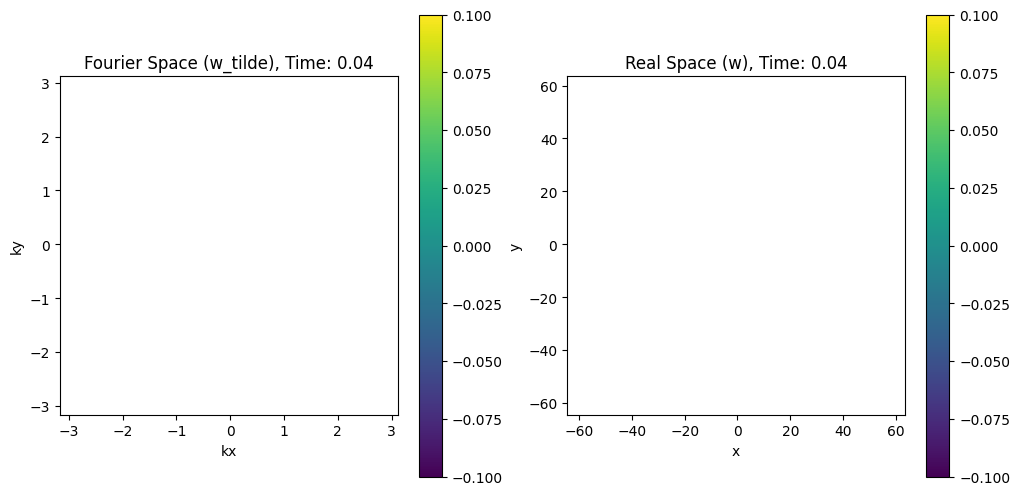

In [6]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(total_time=50, 
                                                                                                Nx = 128, Ny = 128, Lx = 128, Ly = 128)
# Initial conditions

gamma0 = 3.0
non_linear_prefactor = -10000.0
p = 0.0
# w = np.sin(2*np.pi*X/16) + np.sin(2*np.pi*Y/16)
# w = np.exp((-X*X - Y*Y)) * 0.1
# w = np.ones((int(Nx/2), int(Ny/2))) * 0.1
w = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=5.0)
u1 = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=5.0)
u2 = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)), sigma=5.0)

w = np.tile(w, (Nx // w.shape[0], Ny // w.shape[1]))
u1 = np.tile(u1, (Nx // u1.shape[0], Ny // u1.shape[1]))
u2 = np.tile(u2, (Nx // u2.shape[0], Ny // u2.shape[1]))

w_values = []                       # List to store the value of w at (10,10) over time
w_array = []                        # List to store the field w over time
w_tilde_array = []                  # List to store the Fourier transform of w over time

# Fourier transforms of fields
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)


for step in range(steps):

    w_tilde_new_linear = linear_first_order_scheme_for_w(w_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0)
    u1_tilde_new_linear = linear_first_order_scheme_for_u1(u1_tilde, dt, K_squared, K, f_el_prefactor, KY)
    u2_tilde_new_linear = linear_first_order_scheme_for_u2(u2_tilde, dt, K_squared, K, f_el_prefactor, KX)

    w_tilde_new_non_linear = non_linear_first_order_scheme_for_w(w_tilde, u1_tilde, u2_tilde, dt, K_fourth, K_squared, K, f_el_prefactor, gamma0, non_linear_prefactor, p)
    u1_tilde_new_non_linear = non_linear_first_order_scheme_for_u1(w_tilde, u1_tilde, u2_tilde, dt, K_squared, K, f_el_prefactor, KY, non_linear_prefactor)
    u2_tilde_new_non_linear = non_linear_first_order_scheme_for_u2(w_tilde, u1_tilde, u2_tilde, dt, K_squared, K, f_el_prefactor, KX, non_linear_prefactor)

    w_tilde_new = w_tilde_new_linear + w_tilde_new_non_linear
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_non_linear
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_non_linear
    
    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 1000 == 0:

        w_values.append(w[10, 10])
        #print(w_tilde_new_non_linear/w_tilde_new_f_el)
        # plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        # plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        w_array.append(w)
        w_tilde_array.append(w_tilde)
    


# plt.figure(figsize=(10, 6))
# plt.plot(range(0, steps, 1000), w_values, marker='o')
# plt.title('Value of w at (0,0) over time')
# plt.xlabel('Time step')
# plt.ylabel('w(0,0)')
# plt.grid(True)
# plt.show()

animate_w_and_w_tilde(w_array, w_tilde_array, X, Y, KX, KY, dt, 'non_linear_first_order_scheme.mp4')
